## Final Project Submission

Please fill out:
* Student name: Alexandra Yakovleva 
* Student pace: flex / part time 
* Scheduled project review date/time: 1/26/2024 
* Instructor name: Morgan Jones
* Blog post URL:


## Let's begin!
The assignment states the business problem as following:

<i>
Your company is expanding in to new industries to diversify its portfolio. Specifically, they are interested in purchasing and operating airplanes for commercial and private enterprises, but do not know anything about the potential risks of aircraft. You are charged with determining which aircraft are the lowest risk for the company to start this new business endeavor. You must then translate your findings into actionable insights that the head of the new aviation division can use to help decide which aircraft to purchase.
</i>

Here's my roadmap for the asignment:

1. Load the dataset.
2. Get a brief look at dataset to identify columns that can be discarded.
3. For a smaller subset, perform data cleaning and filtering.
4. Visualize info related to Accdents with various Injury rates over the years for different Makes, Models.
5. Saved the cleaned up set for Tabelau use.

I'll use Pandas and Matplotlib to load, clean up, filter, and visualize the aviation accidents data. 

## 1. Dataset

To answer the stated problem, we'll be using [Kaggle's Aviation Accident Database](https://www.kaggle.com/datasets/khsamaha/aviation-accident-database-synopses).
Start with importing Python libraries.

In [19]:
# start with importing Python data loading and data analysis libraries

# for dataframe management
import pandas as pd
# for stats, if needed
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# for loading/saving locally
import os

# display plots inline
%matplotlib inline


Specify directories that contain the data.

In [20]:
# Specify the data directory and the data file name
directory = 'data'
file_name = 'Aviation_Data.csv'


# Join the directory and file name using os.path.join
file_path = os.path.join(directory, file_name)

# Read the CSV file into a DataFrame
aviation_accidents_df = pd.read_csv(file_path, low_memory=False)
aviation_accidents_df.head()
# also load the state codes

file_codes_name = 'USState_Codes.csv'
file_path_StateCodes = os.path.join(directory, file_codes_name)
state_codes_df = pd.read_csv(file_path_StateCodes)

aviation_accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

Each row contains information about an aviation accident (what, when, where, how). 
Our dataset has 31 columns and 90348 entries.
Just by looking at the head of the dataset, there's a lot of missing data. We're going to take a look at the value ranges of the columns next to decide on what information to keep and what to drop.

In [21]:
# Generate info for each column

for column in aviation_accidents_df.columns:
    unique_values = aviation_accidents_df[column].unique()
    count_per_category = aviation_accidents_df[column].value_counts()
    
    print(f"Column: {column}")
    print("Unique values:", unique_values)
    print("Count per category:")
    print(count_per_category)
    print("\n")

Column: Event.Id
Unique values: ['20001218X45444' '20001218X45447' '20061025X01555' ... '20221227106497'
 '20221227106498' '20221230106513']
Count per category:
20001214X45071    3
20001212X19172    3
20220406104897    2
20001211X10541    2
20051121X01862    2
                 ..
20020710X01085    1
20210907103816    1
20030612X00858    1
20130511X50706    1
20001214X37551    1
Name: Event.Id, Length: 87951, dtype: int64


Column: Investigation.Type
Unique values: ['Accident' 'Incident' '25-09-2020' '14-06-2021' '03-11-2020' '24-02-2021'
 '02-02-2021' '05-05-2021' '03-12-2020' '07-12-2020' '06-05-2021'
 '19-11-2020' '04-08-2021' '13-09-2021' '10-06-2021' '14-12-2021'
 '08-06-2021' '24-06-2021' '24-08-2021' '31-03-2021' '27-05-2021'
 '20-05-2021' '18-11-2020' '25-05-2021' '01-06-2021' '15-07-2021'
 '15-10-2021' '26-09-2020' '03-06-2021' '29-09-2021' '28-01-2021'
 '20-10-2021' '11-12-2020' '11-02-2021' '13-12-2021' '06-01-2021'
 '31-08-2021' '04-03-2021' '05-04-2021' '26-01-2021' '29-01-

Column: Registration.Number
Unique values: ['NC6404' 'N5069P' 'N5142R' ... 'N749PJ' 'N210CU' 'N9026P']
Count per category:
NONE      344
UNREG     126
None       65
UNK        13
USAF        9
         ... 
N1851P      1
N9741K      1
N1055V      1
N18778      1
N200DP      1
Name: Registration.Number, Length: 79105, dtype: int64


Column: Make
Unique values: ['Stinson' 'Piper' 'Cessna' ... 'JAMES R DERNOVSEK' 'ORLICAN S R O'
 'ROYSE RALPH L']
Count per category:
Cessna          22227
Piper           12029
CESSNA           4922
Beech            4330
PIPER            2841
                ...  
Nelsen-david        1
Talago              1
Moore-van           1
PENSINGER           1
Shepherd            1
Name: Make, Length: 8237, dtype: int64


Column: Model
Unique values: ['108-3' 'PA24-180' '172M' ... 'ROTORWAY EXEC 162-F' 'KITFOX S5'
 'M-8 EAGLE']
Count per category:
152                    2367
172                    1756
172N                   1164
PA-28-140               932
150      

|Column Name | Column Description | What are we going to do |
|------------|--------------------|------------------------|
| Event.Id   | Event ID, some values repeat, likely when plane A got tangled up with plane B.| Drop it|
|Investigation.Type|Mostly Accident/Incident but dates got mixed into it| Clean up|
|Accident.Number| Similar to event ID| Drop it|
|Event.Date|When it happened| Keep, convert to date|
|Location|Where it happened, nearest city| Icomplete geo info, duplicates Lat/Long. Split into city/state columns|
|Country|Where it happened|Keep it for now|
|Latitude| Where exactly it happened | Important for future viz, data is mixed, convert to same format| 
|Longitude|Where exactly it happened| Important for future viz, data is mixed, convert to same format|
|Airport.Code|Where it hapened| Drop it|
|Airport.Name| Where it hapened | Drop it|
|Injury.Severity| What hapened/How severe | Has mixed data format, needs cleaning. Overall redundant with the oither injury columns| 
|Aircraft.damage| Was the aircraft damaged| Data looks OK, do minor cleaning with the cathegories|
|Aircraft.Category| Type of carrier |Clean up|
|Registration.Number|-| Drop it|
|Make|Manufacturer| Clean up, has duplicates| 
|Model|Model Code|Might need cleanup|
|Amateur.Built|Yes/No| Data looks OK | 
|Number.of.Engines|-|Data looks OK|
|Engine.Type|-|Data needs cleaning| 
|FAR.Description|Code describing the aircraft purpose|Drop it|
|Schedule|If flight was scheduled or not|Drop it|
|Purpose.of.flight|-|There's a possibilty of consolidating values into cathegories that would help with filtering|
|Air.carrier|-|Drop it|
|Total.Fatal.Injuries|-|Clean up|
|Total.Serious.Injuries|-| Clean up|
|Total.Minor.Injuries|-| Clean up|
|Total.Uninjured|-|Clean up|
|Weather.Condition|Weather condition code|Drop it, we don't know what the codes mean|
|Broad.phase.of.flight|Code for the phase of flight|Keep it|
|Report.Status|-|Looks easiest to drop it, or create a column with 'pilot + failure'|
|Publication.Date|-|Drop it|

  ## 2. Selecting relevant columns from the datset.
The rationale behind dropping some of the columns is simple: we won't be able to filter out relevant data based on the information available in the column.


In [22]:
cols_to_remove = ['Event.Id','Accident.Number', 'Airport.Code', 'Airport.Name', 'Registration.Number', \
                  'FAR.Description', 'Schedule','Air.carrier', 'Weather.Condition', \
                  'Broad.phase.of.flight', 'Publication.Date', 'Report.Status']

compact_aa_df = aviation_accidents_df.drop(columns=cols_to_remove)
compact_aa_df.head()


,Investigation.Type,Event.Date,Location,Country,Latitude,Longitude,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
0,Accident,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,Fatal(2),Destroyed,NaN,Stinson,108-3,No,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0
1,Accident,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,Fatal(4),Destroyed,NaN,Piper,PA24-180,No,1.0,Reciprocating,Personal,4.0,0.0,0.0,0.0
2,Accident,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,Fatal(3),Destroyed,NaN,Cessna,172M,No,1.0,Reciprocating,Personal,3.0,NaN,NaN,NaN
3,Accident,1977-06-19,"EUREKA, CA",United States,NaN,NaN,Fatal(2),Destroyed,NaN,Rockwell,112,No,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0
4,Accident,1979-08-02,"Canton, OH",United States,NaN,NaN,Fatal(1),Destroyed,NaN,Cessna,501,No,NaN,NaN,Personal,1.0,2.0,NaN,0.0


## 3. Data Cleaning.

1. Replacing all dates in Investigation.Type with 'Unknown'
2. Converting Event.Date to DateTime format.
3. Splitting Location into City, State, capitalizing the city name.
4. Cleaning up Country.
5. Latitude, Longitude are a mix of DMS (degrees-minutes-seconds) and decimal degrees. We'll need to convert it to a uniform format (decimal degree coordinate).
6. Convert Injury.Severity to Fatal, Non-Fatal, Incident, Unknown
7. Clean up Aircraft.Category (NaN-Unknown)
8. Remove duplicates in Make, Model 
9. For Amateur.Built	Number.of.Engines	Engine.Type, replace NaNs with Unknowns.

In [23]:
#1 'Investigation.Type': Replace dates with Unknown 
valid_values = ['Accident', 'Incident']
compact_aa_df['Investigation.Type'].fillna('Unknown', inplace=True)
compact_aa_df.loc[~compact_aa_df['Investigation.Type'].isin(valid_values), 'Investigation.Type'] = 'Unknown'
compact_aa_df['Investigation.Type'].describe()
#2 'Event.Date' convert to date.time
compact_aa_df['Event.Date'] = pd.to_datetime(compact_aa_df['Event.Date'])

#3 'Location' split into City and State
compact_aa_df['Location'].fillna('Unknown', inplace=True)
city_state = compact_aa_df['Location'].str.replace(' ', '').str.split(',', expand=True)

#insert before country

insert_location = compact_aa_df.columns.get_loc('Location') + 1

# Insert the new column at the specified location
compact_aa_df.insert(insert_location, 'City', city_state.iloc[:, 0].str.title())
compact_aa_df.insert(insert_location + 1, 'State', city_state.iloc[:, 1])

compact_aa_df.drop(columns='Location', inplace=True)

In [24]:
# 'State'contains either a valid state or a duplicate of a country. remove everything that is not a valid state.
# Create a mapping dictionary
abbreviation_mapping = dict(zip(state_codes_df['Abbreviation'], state_codes_df['Abbreviation']))

# Map the values in df2['State']
compact_aa_df['State'] = compact_aa_df['State'].apply(lambda x: abbreviation_mapping.get(x, None))

#4 'Country': replace NaN with Unknown and title
compact_aa_df['Country'].fillna('Unknown', inplace=True)
compact_aa_df['Country'] = compact_aa_df['Country'].str.title()

For #5, we'll implement a function that'll convert DMS geo data into decimal number. As we saw, the data type in the column is either nan, NaN, a decimal coordinate, or a DMS coordinate. 

In [25]:
import re
# check for DMS pattern in a string: ends with 4 types of letters the rest are nubers including 0
def is_dms(coordinate_dms):
    # regular expression pattern for DMS format
    dms_pattern = re.compile(r'^0?\d+?[NSEW]$')
    # If the string matches the DMS pattern
    return bool(dms_pattern.match(coordinate_dms))

def dms2decimal(coordinate):
# Converting DMS data to decimal degree data
   
    # check for float values first
    if isinstance(coordinate, float):
        return coordinate
    
    # do conversion in try-catch block
    decimal_degrees = float('nan')
    try:
        # if its DMS, convert
        if is_dms(coordinate):
            direction = coordinate[-1]
            deg_min_sec = coordinate[:-1]
            # Extract seconds (last two), minutes (middle two), degrees (everything else)
            seconds = int(deg_min_sec[:-2])            
            minutes = int(deg_min_sec[-4:-2])
            degrees = int(deg_min_sec[:-4])

            # Convert to decimal degrees
            decimal_degrees = degrees + (minutes / 60) + (seconds / 3600)

            # Add a negative sign for the Northern or Western hemisphere
            
            if (direction in ['S', 'W']):
                decimal_degrees *= -1
        #if not DMS, try converting to float  
        else:
            decimal_degrees = float(coordinate)
    except TypeError as te:
        print(f'A type error occurred: {te}')
        print(coordinate)
    except ValueError as ve:
        print(f'A value error occurred: {ve}')
        print(coordinate)
        
    return decimal_degrees

In [26]:
#5. 'Latitude', 'Longitude' convert to decimals
non_nan_values_lat = compact_aa_df['Latitude'].notna()
compact_aa_df.loc[non_nan_values_lat, 'Latitude'] = \
    compact_aa_df.loc[non_nan_values_lat, 'Latitude'].apply(dms2decimal)

non_nan_values_long = compact_aa_df['Longitude'].notna()
compact_aa_df.loc[non_nan_values_long, 'Longitude'] = \
    compact_aa_df.loc[non_nan_values_long, 'Longitude'].apply(dms2decimal)

In [27]:
# 6.'Injury.Severity': replace all Fatal(xx) with Fatal, replace 'Minor' or 'Serious' with Non-Fatal
compact_aa_df['Injury.Severity'] = compact_aa_df['Injury.Severity'].str.replace('^Fatal.*', 'Fatal')
compact_aa_df['Injury.Severity'] = compact_aa_df['Injury.Severity'].str.replace('Minor', 'Non-Fatal')
compact_aa_df['Injury.Severity'] = compact_aa_df['Injury.Severity'].str.replace('Serious', 'Non-Fatal')

compact_aa_df['Injury.Severity'].fillna('Unknown', inplace=True)

#'Aircraft.damage': replace nan values with Unknown 
compact_aa_df['Aircraft.damage'].fillna('Unknown', inplace=True)
# rename the column to match overall style
compact_aa_df.rename(columns={'Aircraft.damage': 'Aircraft.Damage'}, inplace=True)

# 7. 'Aircraft.Category' replace nan with Unknown, 
# replace ULTR with Ultralight, WSFT with Weightshift, UNK with Unknown 
compact_aa_df['Aircraft.Category'].fillna('Unknown', inplace=True)
compact_aa_df['Aircraft.Category'] = compact_aa_df['Aircraft.Category'].str.replace('ULTR', 'Ultralight')
compact_aa_df['Aircraft.Category'] = compact_aa_df['Aircraft.Category'].str.replace('WSFT', 'Weight-Shift')
compact_aa_df['Aircraft.Category'] = compact_aa_df['Aircraft.Category'].str.replace('UNK', 'Unknown')


# 8 'Make': Use str.title for all aircrtaft makes to get rid of duplicates
# 'Model'  
compact_aa_df['Make'] = compact_aa_df['Make'].str.title()
compact_aa_df['Model'].fillna('Unknown', inplace=True)

# 9. Purpose.of.flight # replace ULTR with Ultralight, WSFT with Weightshift, UNK with Unknown 
#compact_aa_df['Aircraft.Category'] = compact_aa_df['Aircraft.Category'].str.replace('ULTR', 'Ultralight')
#compact_aa_df['Aircraft.Category'] = compact_aa_df['Aircraft.Category'].str.replace('WSFT', 'Weight-Shift')
#compact_aa_df['Aircraft.Category'] = compact_aa_df['Aircraft.Category'].str.replace('UNK', 'Unknown')

In [28]:
# 9 'Amateur.Built' replace NA with Unknown
compact_aa_df['Amateur.Built'].fillna('Unknown', inplace=True)


for column in compact_aa_df.columns:
    unique_values = compact_aa_df[column].unique()
    count_per_category = compact_aa_df[column].value_counts()
    
    print(f"Column: {column}")
    print("Unique values:", unique_values)
    print("Count per category:")
    print(count_per_category)
    print("\n")

Column: Investigation.Type
Unique values: ['Accident' 'Incident' 'Unknown']
Count per category:
Accident    85015
Incident     3874
Unknown      1459
Name: Investigation.Type, dtype: int64


Column: Event.Date
Unique values: ['1948-10-24T00:00:00.000000000' '1962-07-19T00:00:00.000000000'
 '1974-08-30T00:00:00.000000000' ... '2022-12-22T00:00:00.000000000'
 '2022-12-26T00:00:00.000000000' '2022-12-29T00:00:00.000000000']
Count per category:
1982-05-16    25
1984-06-30    25
2000-07-08    25
1983-06-05    24
1983-08-05    24
              ..
2020-03-23     1
2013-12-10     1
2014-11-06     1
2013-08-19     1
2016-12-22     1
Name: Event.Date, Length: 14782, dtype: int64


Column: City
Unique values: ['Moosecreek' 'Bridgeport' 'Saltville' ... 'Sanmanual' 'Auburnhills'
 'Brasnorte']
Count per category:
Unknown            1535
Anchorage           548
Houston             283
Miami               283
Albuquerque         265
                   ... 
Hamptonbays           1
Cherrytree           

## 4. Exploratory analysis.

We'd like to look at injury distribution for several columns that contain values not contributing to our analysis goal.

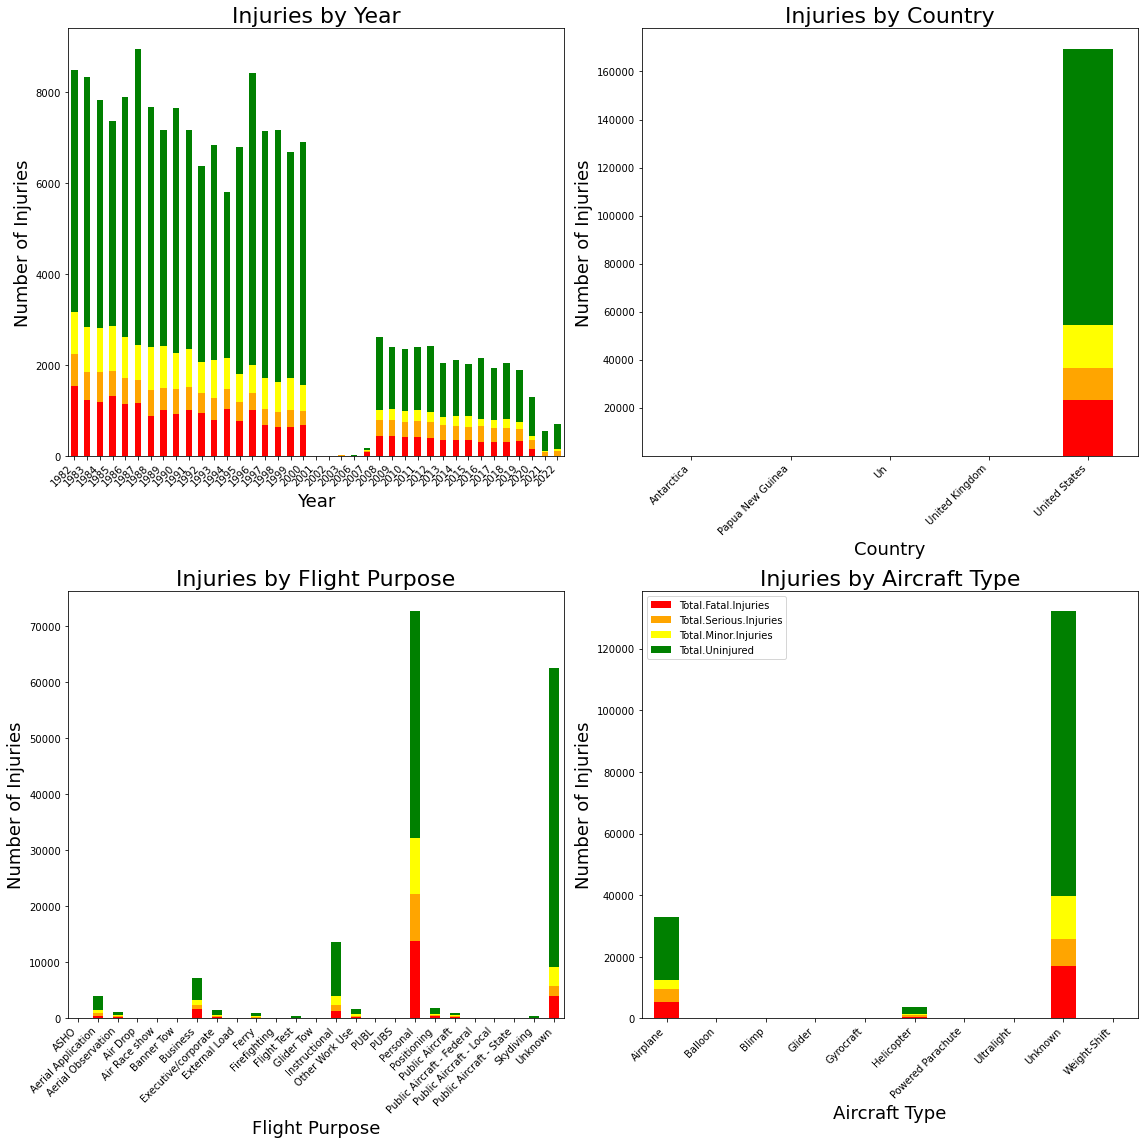

In [87]:
# Drop NaNs, add Year Column
df_accidents_exploratory = compact_aa_df.drop(columns=['Latitude', 'Longitude'])

df_accidents_clean = df_accidents_exploratory.dropna().copy()
df_accidents_clean['Year'] = df_accidents_clean['Event.Date'].dt.year.astype(int)

# Filter years > 1982 
df_accidents_clean = df_accidents_clean[df_accidents_clean['Investigation.Type'] != 'Incident']
df_accidents_clean_after_1982 = df_accidents_clean[df_accidents_clean['Year'] >= 1982]

# injury by years
injury_by_year_cols = ['Year', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', \
                       'Total.Minor.Injuries', 'Total.Uninjured']
df_agg_inj_by_year = df_accidents_clean_after_1982[injury_by_year_cols].groupby('Year').sum()

#injury by country
injury_by_country_cols = ['Country', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', \
                          'Total.Minor.Injuries', 'Total.Uninjured']
df_agg_inj_by_country = df_accidents_clean_after_1982[injury_by_country_cols].groupby('Country').sum()

#injury by purpose of the flight
injury_by_flight_cols = ['Purpose.of.flight', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', \
                         'Total.Minor.Injuries', 'Total.Uninjured']
df_agg_inj_by_flight = df_accidents_clean_after_1982[injury_by_flight_cols].groupby('Purpose.of.flight').sum()

#injury by aircraft.category
injury_by_cat_cols = ['Aircraft.Category', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', \
                      'Total.Minor.Injuries', 'Total.Uninjured']
df_agg_inj_by_cat = df_accidents_clean_after_1982[injury_by_cat_cols].groupby('Aircraft.Category').sum()

# Plotting
colors = ['red', 'orange', 'yellow', 'green']
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

df_agg_inj_by_year.plot(kind='bar', stacked=True, ax=axs[0, 0], color = colors)
# Labels
axs[0, 0].set_title('Injuries by Year', fontsize = 22)
axs[0, 0].set_xlabel('Year', fontsize = 18)
axs[0, 0].set_ylabel('Number of Injuries', fontsize = 18)
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45, ha='right')
legend = axs[0, 0].get_legend()
legend.remove()
# Plotting
df_agg_inj_by_country.plot(kind='bar', stacked=True, ax=axs[0, 1], color=colors)
# Labels
axs[0, 1].set_title('Injuries by Country', fontsize = 22)
axs[0, 1].set_xlabel('Country', fontsize = 18)
axs[0, 1].set_ylabel('Number of Injuries', fontsize = 18)
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')
legend = axs[0, 1].get_legend()
legend.remove()

# Plotting
df_agg_inj_by_flight.plot(kind='bar', stacked=True, ax=axs[1, 0], color=colors)
# Labels
axs[1, 0].set_title('Injuries by Flight Purpose', fontsize = 22)
axs[1, 0].set_xlabel('Flight Purpose', fontsize = 18)
axs[1, 0].set_ylabel('Number of Injuries', fontsize = 18)
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right')
legend = axs[1, 0].get_legend()
legend.remove()
# Plotting
df_agg_inj_by_cat.plot(kind='bar', stacked=True, ax=axs[1, 1], color=colors)
# Labels
axs[1, 1].set_title('Injuries by Aircraft Type', fontsize = 22)
axs[1, 1].set_xlabel('Aircraft Type', fontsize = 18)
axs[1, 1].set_ylabel('Number of Injuries', fontsize = 18)
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right');
#legend = axs[1, 1].get_legend()
#legend.remove()


plt.tight_layout()

# Set common legend for the entire figure
#fig.legend(labels=df_agg_inj_by_year.columns[0:], title='Injury Type', \
           #bbox_to_anchor=(0.5, 0.53), loc='center', ncol=1, fontsize = 14);


As we can see, 

 Now let's look at the aircraft stats: distribution of accidents by Make, Model, Flight Type, Engine Type.
Then we'll look into Plane Damage. 